In [37]:
import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Define paths
images_path = 'data/Images'
captions_file = 'data/captions.txt'

In [5]:
# Creates a dictionary, with the image name as the key, and the caption as the value
captions = defaultdict(list)
with open(captions_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        image, caption = line.strip().split(',', 1)
        captions[image].append(caption)

In [6]:
# Example caption
captions['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
# Preprocess captions and clean the text up
def clean_caption(caption):
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove words with numbers and words of length 1
    # If the word is of length 1, or the word contains a digit, remove it from the cpation
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    # Convert to lowercase
    caption = caption.lower()
    return caption

# Surprisingly loops over all keys
for image in captions:
    # Loops over all strings, and cleans the captions
    captions[image] = [clean_caption(caption) for caption in captions[image]]

In [8]:
# Define image transformation
transform = transforms.Compose([
    # CHANGE image size
    transforms.Resize((184, 184)),
    transforms.ToTensor(),
    # TODO: Update this part of the function
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure the image has 3 channels
])

# Load image function helper
def load_image(image_file):
    image = Image.open(os.path.join(images_path, image_file)).convert('RGB')
    image = transform(image)
    return image

In [9]:
# Build vocabulary
word_counter = Counter()
for image, caption_list in captions.items():
    # Loops through list of strings
    for caption in caption_list:
        word_counter.update(caption.split())

In [10]:
# Create dictionaries for words
vocab_threshold = 3
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4  # Including <PAD>, <START>, <END>, <UNK>

In [11]:
# Add special tokens
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3
itos = {idx: word for word, idx in stoi.items()}

In [12]:
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

def pad_caption(caption, max_length):
    # This actually pads one less than the max, which is not intended. But, we will keep this anyways
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [13]:
# Calculate the max length of the cpations
# To unpack this, we are looping over the defaultdict captions. We get the list of strings called caption_list, and loop over all lists of strings in captions, and also loop over all captions in the list
# This is a very complex string comprehension
max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list) + 2
max_length

34

In [14]:
# Loops over all image keys, all caption lists, all captions in caption lists, encodes them, and pads them
encoded_captions = defaultdict(list)

for image in captions:
    for caption in captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_captions[image].append(padded)

In [15]:
# Function to create input and target sequences
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

In [16]:
# Create input and target sequences for all captions
input_sequences = defaultdict(list)
target_sequences = defaultdict(list)

for image, caption_list in encoded_captions.items():
    for caption in caption_list:
        # Loop through all captions in all caption_lists, and create the corresponding token lists
        input_seq, target_seq = create_sequences(caption)
        # Create another defaultdict() that allows for indexing of the processed list tokens
        input_sequences[image].append(input_seq)
        target_sequences[image].append(target_seq)

In [17]:
# Creating randomized batches
image_keys = list(captions.keys())

In [18]:
torch.manual_seed(1337)

In [19]:
# Shuffle the dataset
shuffled_indices = torch.randperm(len(image_keys)).tolist()
image_keys = [image_keys[i] for i in shuffled_indices]

In [20]:
# Split the dataset (80% training, 20% validation)
split_index = int(0.8 * len(image_keys))
train_keys = image_keys[:split_index]
val_keys = image_keys[split_index:]

In [21]:
# Train and validation sets
train_captions = {key: captions[key] for key in train_keys}
val_captions = {key: captions[key] for key in val_keys}
train_input_sequences = {key: input_sequences[key] for key in train_keys}
val_input_sequences = {key: input_sequences[key] for key in val_keys}
train_target_sequences = {key: target_sequences[key] for key in train_keys}
val_target_sequences = {key: target_sequences[key] for key in val_keys}

In [22]:
def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []
    
    selected_images = random.sample(list(caption_dict.keys()), batch_size)
    for image in selected_images:
        # Pick a random index from one of the caption lists
        selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
        # Add the corresponding image caption
        input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
        # Get the corresponding target_caption
        target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
        # Add the image to the corresponding image to the image set
        images_batch.append(load_image(image))
    
    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)
    
    return images_batch, input_captions_batch, target_captions_batch


In [23]:
# Example usage:
batch_size = 4
images_batch, input_captions_batch, target_captions_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)


In [24]:
images_batch.shape

torch.Size([4, 3, 184, 184])

In [25]:
input_captions_batch.shape

torch.Size([4, 33])

In [26]:
target_captions_batch.shape

torch.Size([4, 33])

Training example:


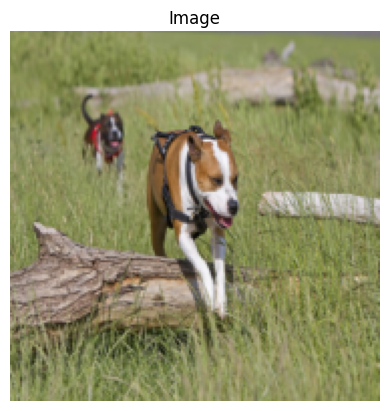

Input Caption: <START> brown and white dog is leaping over log in field while another dog follows behind it <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: brown and white dog is leaping over log in field while another dog follows behind it <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Validation example:


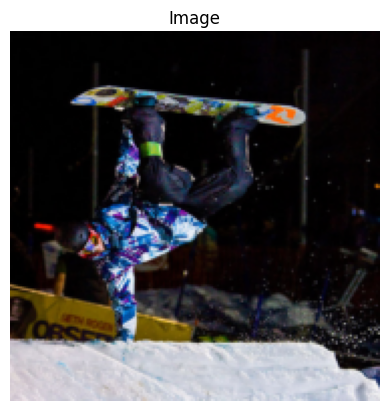

Input Caption: <START> snowboarder doing onehanded <UNK> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: snowboarder doing onehanded <UNK> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [28]:
def visualize_example(caption_dict, input_seq_dict, target_seq_dict):
    
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Get the corresponding caption inputs and targets
    input_caption_encoded = input_seq_dict[random_image][caption_idx]
    target_caption_encoded = target_seq_dict[random_image][caption_idx]
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)
    
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the input and target captions
    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

# Example usage:
print("Training example:")
visualize_example(train_captions, train_input_sequences, train_target_sequences)

print("Validation example:")
visualize_example(val_captions, val_input_sequences, val_target_sequences)


In [29]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(ResBlockMLP, self).__init__()
        
        # Define layer normalization for input size
        self.norm1 = nn.LayerNorm(input_size)
        
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        # Layer normalization for input size // 2
        self.norm2 = nn.LayerNorm(input_size//2)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        # Final fully connected layer
        self.fc3 = nn.Linear(input_size, output_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        
        # Apply layer normalization and activation function
        x = self.act(self.norm1(x))
        
        # Calculate skip connection
        skip = self.fc3(x)
        
        # Apply layer normalization, fully connected layer, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        # Add skip connection
        return x + skip

In [30]:
class ConvNet(nn.Module):
    def __init__(self, channels_in, dropout):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(channels_in, out_channels = 16, padding = 1, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, out_channels = 32, padding = 1, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, out_channels = 64, padding = 1, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(dropout)

        self.act = nn.ReLU()
        
        self.linear = nn.Linear(33856, 4096)
    
    def forward(self, inputs): # (224, 224, 3)
        
        out = self.maxpool(self.dropout(self.bn1(self.act(self.conv1(inputs))))) # (112, 112, 32)
        
        out = self.maxpool(self.dropout(self.bn2(self.act(self.conv2(out))))) # (56, 56, 64)
        
        out = self.maxpool(self.dropout(self.bn3(self.act(self.conv3(out))))) # (28, 28, 128)
        
        out = out.flatten(start_dim = 1)

        return self.linear(out) # (B, 4096)
        

In [31]:
class Decoder(nn.Module):
    def __init__(self, channels_in, dropout, vocab_size, emb_size, hidden_size, num_layers, num_blocks):
        super(Decoder, self).__init__()
        
        self.convnet = ConvNet(channels_in = 3, dropout = dropout)

        self.linear = nn.Linear(4096, hidden_size)
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, bias = False, batch_first = True)

        # Residual blocks
        self.blocks = nn.Sequential(*[ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)])

        # Activation function
        self.act = nn.ELU()
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    # Memory in will always be a matrice of zeros
    def forward(self, images, captions, mem_in):

        features = self.convnet(images) # (B, 4096)
        features = self.linear(features) # (B, hidden_size)
        features = features.unsqueeze(0) # (1, B, hidden_size)

        batch_size = images.size(0)
        hidden_size = self.lstm.hidden_size
        num_layers = self.lstm.num_layers

        captions = self.embedding(captions)
        
        outputs, (hidden_out, mem_out) = self.lstm(captions, (features, mem_in))
        # x = (B, T, emb_size)
        # hidden_out = (num_layers, B, hidden_size)
        # mem_out = (num_layers, B, hidden_size)

        outputs = self.act(self.blocks(outputs))
        
        return self.fc_out(outputs) 

In [32]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

num_iterations = 1000

hidden_size = 256

learning_rate = 1e-5

channels_in = 3

dropout = 0.2

vocab_size = len(stoi)

emb_size = 128

hidden_size = 256

# LSTM layers
num_layers = 1

# ResBlocks
num_blocks = 1

batch_size = 4

max_length = max_length

# Paddding 1 less, than the max_length
time_steps = max_length - 1

In [33]:
model = Decoder(channels_in = channels_in, dropout = dropout, vocab_size = vocab_size, emb_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, num_blocks = num_blocks).to(device)

memory = torch.zeros(num_layers, batch_size, hidden_size, device=device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

training_loss = []

val_loss = []

In [34]:
# Let's see how many Parameters our model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters, %d Million" % (num_model_params, num_model_params//1e6 ) )

This model Has 141595618 Parameters, 141 Million


In [57]:
for iteration in range(num_iterations):

    # Training
    model.train()

    image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)

    image_batch = image_batch.to(device)
    caption_batch = caption_batch.to(device)
    label_batch = label_batch.to(device)
    
    outputs = model(image_batch, caption_batch, memory)
    
    outputs = outputs.reshape(batch_size * time_steps, -1)

    label_batch = label_batch.reshape(batch_size * time_steps)

    loss = loss_fn(outputs, label_batch)

    training_loss.append(loss.item())

    if iteration % 30 == 0: 
        print("iteration", iteration, "training loss:", loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Evaluate every so often
    if iteration % 30 == 0:
        
        model.eval()

        image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, batch_size)
    
        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        label_batch = label_batch.to(device)
        
        outputs = model(image_batch, caption_batch, memory)
        
        outputs = outputs.reshape(batch_size * time_steps, -1)
    
        label_batch = label_batch.reshape(batch_size * time_steps)
    
        loss = loss_fn(outputs, label_batch)

        val_loss.append(loss.item())
        
        print("iteration", iteration, "val loss:", loss.item())
    
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

iteration 0 training loss: 3.1500582695007324
iteration 0 val loss: 2.6781744956970215
iteration 30 training loss: 3.1874356269836426
iteration 30 val loss: 1.8802522420883179
iteration 60 training loss: 3.2194268703460693
iteration 60 val loss: 2.998366117477417
iteration 90 training loss: 3.325021982192993
iteration 90 val loss: 2.8470776081085205
iteration 120 training loss: 2.704714059829712
iteration 120 val loss: 2.516799211502075
iteration 150 training loss: 2.0093088150024414
iteration 150 val loss: 2.363694429397583
iteration 180 training loss: 2.209968090057373
iteration 180 val loss: 1.8794314861297607
iteration 210 training loss: 2.4592437744140625
iteration 210 val loss: 2.87326717376709
iteration 240 training loss: 2.526986598968506
iteration 240 val loss: 2.8269498348236084
iteration 270 training loss: 2.093416690826416
iteration 270 val loss: 2.291257858276367


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training loss')

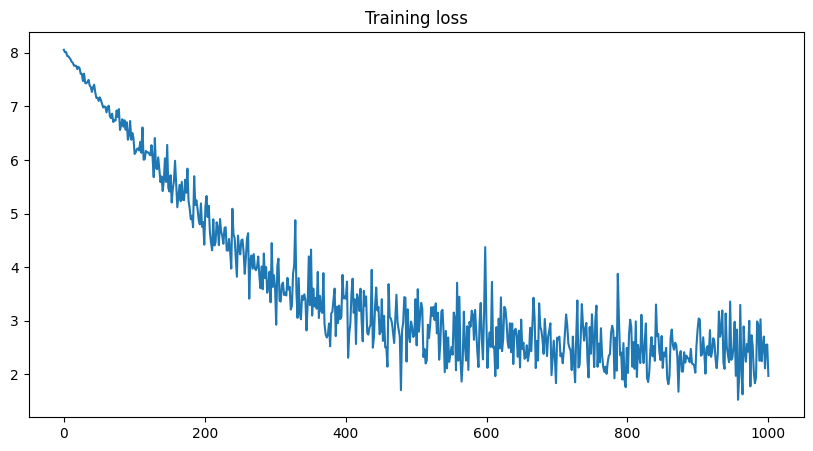

In [58]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_iterations, len(training_loss))
plt.plot(train_x, training_loss)
plt.title("Training loss")

Text(0.5, 1.0, 'Val loss')

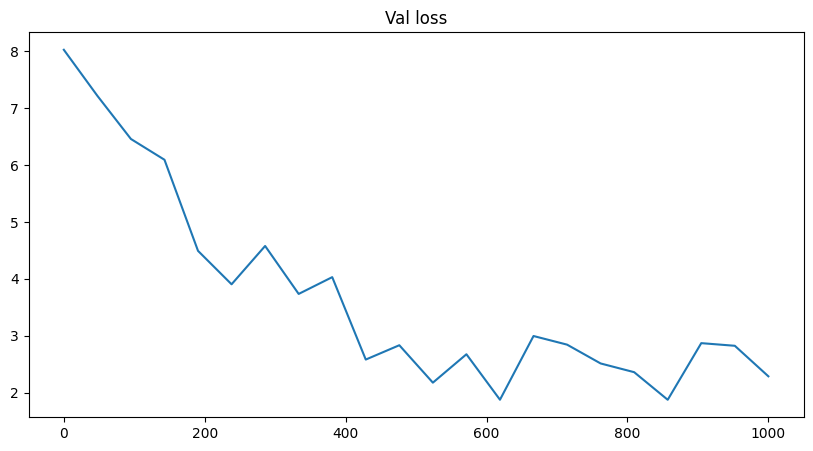

In [59]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_iterations, len(val_loss))
plt.plot(train_x, val_loss)
plt.title("Val loss")

In [54]:
max_length = 30

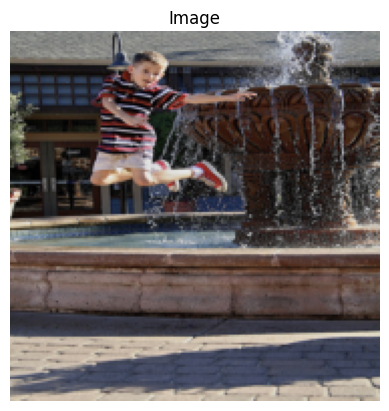

Original Caption: <START> boy in striped shirt is jumping in front of water fountain <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: dead background skatepark facepaint bites attractive star trailer <PAD>
Generated Caption: travels trees picture who object van wheelchair cricket banner bank cloudy climbers rounding medium jackets wigs first golf firetruck whispering interact terrain zoo haired labrador pass fancy receives tongues grabbing
Generated Caption: female <PAD>
Generated Caption: routine station owners workers licking gather group is lie monitor breeds games york elegant about bricks goalkeeper parasailer huskies rainy trailer hell man advertisement keeps mask called drives stand lacrosse
Generated Caption: most <PAD>


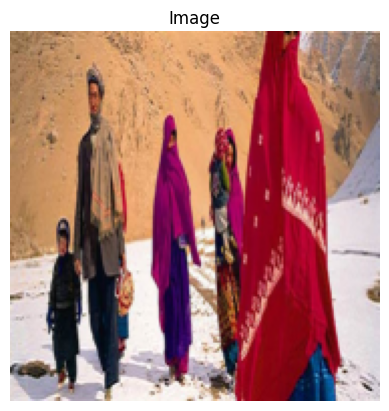

Original Caption: <START> family in colorful clothing walking in the snow <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: oar called bedroom stool eight nap headdress drum carying touching tricycle laughs craft flies learning throw seagull single cords embracing defenders placing creature impeach flower headband eyes outdoor three pieces
Generated Caption: younger bracelet pickup aims than eastern dinner deer snowbank somthing inground sharp stomach cookie thin sneakers alligator michael soccer first across sharing box bottoms cracked rain filled tunnel embraces drummer
Generated Caption: numbered long playing really participating surprised hockey dj streaks sunny busy pinata horseback trash snowboard bounce crab partly modern shed gravel brunette scary pushes chains piercing relaxing tourists thin earth
Generated Caption: long somersault walks wooden helps hug escalator d

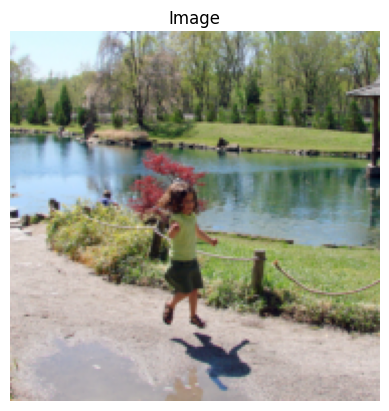

Original Caption: <START> young girl is jumping on gravel road near pond <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: deck lips infant gesture boulder work boston sundown toys scottish active curve atop float seems shovels jungle tattoos fan mouth smelling bridge sheep butterfly descends ninja starts right winding coats
Generated Caption: nike training silhouetted passing caught arrow brown checkered leaps men saxophone drinks paved inside sweatshirts swimming sells tags inflatable coming upper pasta balcony paved video costumed arch father dolphin reaches
Generated Caption: with countertop <PAD>
Generated Caption: drawing silver climbers at cage turn other goats silhouette card balances wade boxers colourful control breeds casts test sticks approaching submerged cream counter furniture heavy marks busy giving tee wine
Generated Caption: <PAD>


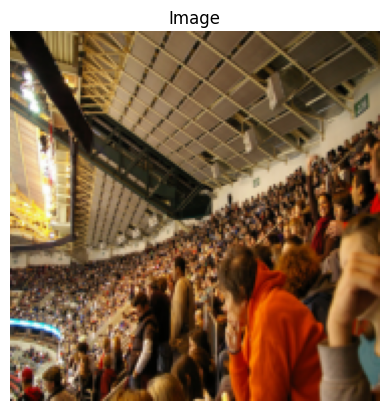

Original Caption: <START> crowd sitting in an indoor stadium <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: treelined <PAD>
Generated Caption: bumpy by speaks seagulls terrace surfboard pedestrian appears obstacle try sunglasses pitch gloved skipping shoreline flute something hall hospital lunges electric spread numbers dreadlocks routine political serving facepaint speeding suspenders
Generated Caption: emerging luggage workers children elaborate playpen cars will snowy individual windsurfing booth bunny bear clay end overhang whist tethered area ski docked float diner partly kids spiral hides connected pursued
Generated Caption: collar huddle interviews pouncing treads gold fur native pairs policeman river no opponent cat angels lightcolored small starting tricolored tattooed steering parachutes religious powder balances ambulance pets his lease mountains
Ge

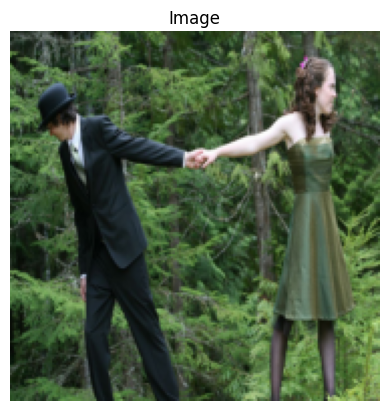

Original Caption: <START> man and woman holding hands try to go their opposite <UNK> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: few rodeo teams ends electronic evil floor veil massage advertisement retrieves twilight shelter pointy great celebrate electric carriage museum upset policeman wig mean work statue fishing earphones ducks lunch woman
Generated Caption: defends air items drinks <PAD>
Generated Caption: shapes party runner robe products cute how fountain toboggan slightly feet bitten claus cat curtain style carry in selling shower wrestler couple smoking and putting over bug ancient multicolor gloved
Generated Caption: restaurant class chocolate plants amongst music casts american soaked backwards pillows york flipping look branch monkey mountaineer buckets presses umbrella smokes hell view group rocky lane nearly airplane lays winnie
Generated Caption: cords main dogs paint ch

In [60]:
def sample_caption(image, max_length=30):

    model.eval()
    
    # Initialize the <sos> token
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0)  # Add time dimension (1, 1, hidden_size)
    
    input_tokens = sos_token  # Start with <sos> token
    generated_caption = []
    
    for _ in range(max_length):
        input_embed = model.embedding(input_tokens)  # Embed the input tokens
        
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        output, _ = model.lstm(input_embed, (features, torch.zeros_like(features)))
        
        output = model.blocks(output)
        
        output = model.fc_out(output)  # Output shape: (1, seq_length, vocab_size)
        
        # Softmax across the last layer and sample from the distribution of vocabularies at the last time step
        probabilities = F.softmax(output[:, -1, :], dim=-1)
        
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        # Append the generated token to the caption
        generated_caption.append(itos[next_token.item()])
        
        # Concatenate the current input token with previously generated tokens
        input_tokens = torch.cat([input_tokens, next_token], dim=1)

        # If <eos> token is generated or <pad> token (assumed stoi['<pad>'] == 0), stop
        if next_token.item() == stoi['<END>'] or next_token.item() == stoi['<PAD>']:
            break
    
    return generated_caption


def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length=30):
    
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the original caption
    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")

    for _ in range(5):
        # Generate a caption using the model
        generated_caption = sample_caption(image_tensor, max_length)
        
        # Print the generated caption
        print(f"Generated Caption: {' '.join(generated_caption)}")

# Example usage:
num_samples = 5
for _ in range (num_samples):
    visualize_example(val_captions, val_input_sequences, val_target_sequences, max_length = max_length)
